# Portfólio — Agro IBGE (SIDRA)

Limpeza → unificação → indicadores → gráficos → **projeções de Big Bags** para Açúcar, Fertilizantes (proxy: Cereais/Leguminosas/Oleaginosas) e Sementes/Grãos (Soja+Milho+Arroz+Trigo).

In [1]:

import pandas as pd, re
import matplotlib.pyplot as plt

# Coloque o arquivo Excel nesta mesma pasta com esse nome.
excel_path = "dados_sidra_ibge.xlsx"

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)


In [2]:
import math
import matplotlib.pyplot as plt

def fmt_br(x, nd=0):
    """Formata número no padrão pt-BR (milhar com ponto e decimais com vírgula)."""
    s = f"{x:,.{nd}f}"
    return s.replace(",", "X").replace(".", ",").replace("X", ".")

def add_bar_labels(container, axis="h", nd=0, pad=3):
    """
    Adiciona rótulos às barras (horizontal: axis='h'; vertical: axis='v').
    Usa bar_label (matplotlib >= 3.4) ou fallback manual.
    """
    ax = plt.gca()
    try:
        labels = [fmt_br(b.get_width() if axis=="h" else b.get_height(), nd) for b in container]
        ax.bar_label(container, labels=labels, padding=pad)
    except Exception:
        for b in container:
            if axis == "h":
                val = b.get_width()
                ax.text(val + pad, b.get_y() + b.get_height()/2, fmt_br(val, nd), va="center")
            else:
                val = b.get_height()
                ax.text(b.get_x() + b.get_width()/2, val + pad, fmt_br(val, nd), ha="center", va="bottom")



In [3]:

def tidy_from_sheet(sheet_name: str, excel_path: str):
    df = pd.read_excel(excel_path, sheet_name=sheet_name, header=None)

    # descobrir a linha que contém "Safra 2024 | Safra 2025"
    header_row = None
    for i in range(0, 12):
        row = df.iloc[i].astype(str).tolist()
        if any(re.search(r"Safra\s*\d{4}", x) for x in row):
            header_row = i
            break
    if header_row is None:
        header_row = 4  # fallback compatível com SIDRA

    # anos nas colunas a partir da 3ª coluna
    year_cells = df.iloc[header_row, 2:].tolist()
    years = [int(re.search(r"(\d{4})", str(y)).group(1))
             for y in year_cells if pd.notna(y) and re.search(r"(\d{4})", str(y))]

    # dados começam logo abaixo da linha de cabeçalho
    data = df.iloc[header_row+1:, :2+len(years)].copy()
    data.columns = ["grupo_produto", "produto", *years]
    data = data.dropna(how="all")
    data["grupo_produto"] = data["grupo_produto"].ffill()

    long = data.melt(
        id_vars=["grupo_produto","produto"],
        value_vars=years, var_name="ano_safra", value_name="valor"
    )
    long = long.dropna(subset=["valor"])
    long["grupo"] = long["grupo_produto"].astype(str).str.strip()
    long["produto"] = long["produto"].astype(str).str.strip()
    long = long.drop(columns=["grupo_produto"])

    long["variavel"] = sheet_name
    long["unidade"] = "Hectares" if "Área" in sheet_name else "Toneladas"
    long["ano_safra"] = long["ano_safra"].astype(int)
    long["valor"] = pd.to_numeric(long["valor"], errors="coerce")
    long = long.dropna(subset=["valor"])
    return long


In [16]:

area_plantada = tidy_from_sheet("Área plantada (Hectares)", excel_path)
area_colhida  = tidy_from_sheet("Área colhida (Hectares)", excel_path)
producao      = tidy_from_sheet("Produção (Toneladas)", excel_path)

tidy = pd.concat([area_plantada, area_colhida, producao], ignore_index=True)

# remover prefixos de numeração (ex.: "1.2 "):
tidy["produto_clean"] = tidy["produto"].str.replace(r"^\d+(?:\.\d+)*\s+", "", regex=True)

pivot = tidy.pivot_table(
    index=["grupo","produto_clean","ano_safra"],
    columns="variavel", values="valor", aggfunc="sum"
).reset_index()
pivot.columns.name = None
pivot = pivot.rename(columns={
    "Área plantada (Hectares)": "area_plantada_ha",
    "Área colhida (Hectares)": "area_colhida_ha",
    "Produção (Toneladas)": "producao_t"
})
pivot["produtividade_t_ha"] = (pivot["producao_t"] / pivot["area_colhida_ha"]).round(3)

display(pivot.sort_values(["grupo","produto_clean"]))


,grupo,produto_clean,ano_safra,producao_t,area_colhida_ha,area_plantada_ha,produtividade_t_ha
0,Brasil,Algodão herbáceo,2024,8866378.0,2027769.0,2027897.0,4.372
1,Brasil,Algodão herbáceo,2025,9493294.0,2142191.0,2142637.0,4.432
2,Brasil,Amendoim (1ª Safra),2024,780032.0,269219.0,273395.0,2.897
3,Brasil,Amendoim (1ª Safra),2025,1196288.0,323537.0,324015.0,3.698
4,Brasil,Amendoim (2ª Safra),2024,13800.0,8337.0,8337.0,1.655
...,...,...,...,...,...,...,...
63,Brasil,Trigo,2025,7700024.0,2418293.0,2418603.0,3.184
64,Brasil,Triticale,2024,43729.0,17507.0,17604.0,2.498
65,Brasil,Triticale,2025,41116.0,13707.0,13707.0,3.000
66,Brasil,Uva,2024,1763397.0,82451.0,82902.0,21.387


In [17]:

tidy.to_csv("ibge_agro_tidy.csv", index=False, encoding="utf-8")
pivot.to_csv("ibge_agro_indicadores.csv", index=False, encoding="utf-8")
print("Salvo: ibge_agro_tidy.csv | ibge_agro_indicadores.csv")


Salvo: ibge_agro_tidy.csv | ibge_agro_indicadores.csv


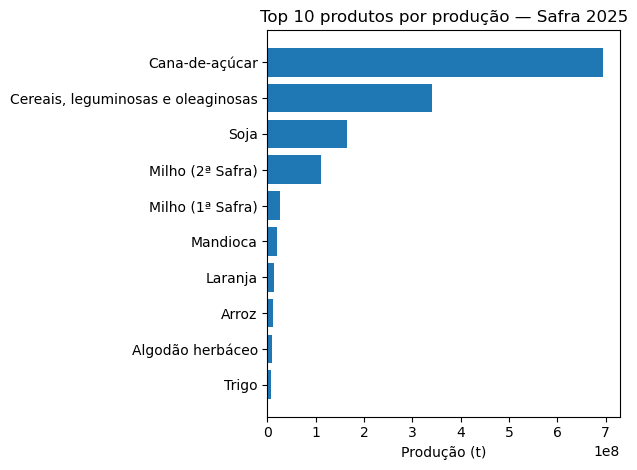

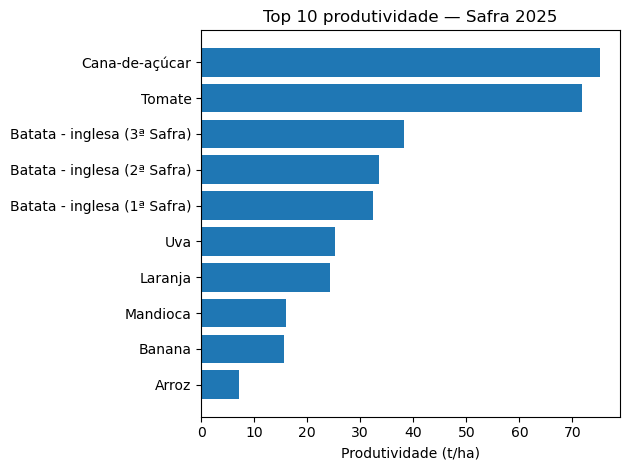

In [18]:

ano_max = int(pivot["ano_safra"].max())
df_ano  = pivot[(pivot["ano_safra"]==ano_max) & (~pivot["produto_clean"].str.lower().eq("total"))].copy()

# Top 10 por produção
top10 = df_ano.sort_values("producao_t", ascending=False).head(10)
plt.figure()
plt.barh(top10["produto_clean"][::-1], top10["producao_t"][::-1])
plt.xlabel("Produção (t)")
plt.title(f"Top 10 produtos por produção — Safra {ano_max}")
plt.tight_layout(); plt.show()

# Top 10 por produtividade (filtro para evitar outlier de área muito pequena)
df_valid = df_ano[df_ano["area_colhida_ha"] >= 10000]
top10p = df_valid.sort_values("produtividade_t_ha", ascending=False).head(10)
plt.figure()
plt.barh(top10p["produto_clean"][::-1], top10p["produtividade_t_ha"][::-1])
plt.xlabel("Produtividade (t/ha)")
plt.title(f"Top 10 produtividade — Safra {ano_max}")
plt.tight_layout(); plt.show()


## Projeções de Big Bags por Segmento (Açúcar, Fertilizantes, Sementes/Grãos)

In [7]:

ano_ref = int(pivot["ano_safra"].max())
prod_ano = pivot[pivot["ano_safra"]==ano_ref][["produto_clean","producao_t"]].dropna()

SEG_ACUCAR          = ["Cana-de-açúcar"]
SEG_SEMENTES_GRAOS  = ["Soja", "Milho", "Arroz", "Trigo"]

def producao_total_itens(df, itens):
    mask = False
    for it in itens:
        mask = mask | df["produto_clean"].str.contains(fr"^{it}\b", case=False, regex=True)
    return df.loc[mask, "producao_t"].sum()

def producao_total_categoria(df, categoria_prefixo: str):
    return df.loc[df["produto_clean"].str.contains(fr"^{categoria_prefixo}\b", case=False, regex=True), "producao_t"].sum()

def estimar_bigbags(producao_t, capacidade_bag_t=1.0):
    if capacidade_bag_t <= 0:
        raise ValueError("Capacidade do Big Bag deve ser positiva.")
    return producao_t / capacidade_bag_t

# Açúcar
prod_acucar_t = producao_total_itens(prod_ano, SEG_ACUCAR)
# Fertilizantes → proxy: Cereais/Leguminosas/Oleaginosas (nível categoria)
prod_fert_t   = producao_total_categoria(prod_ano, "Cereais, leguminosas e oleaginosas")
# Sementes/Grãos → Soja + Milho + Arroz + Trigo
prod_sem_gr_t = producao_total_itens(prod_ano, SEG_SEMENTES_GRAOS)

cap = 1.0  # 1 t/bag (ajuste no próximo bloco de cenários)
resumo = pd.DataFrame({
    "segmento": ["Açúcar", "Fertilizantes (proxy cereais)", "Sementes/Grãos (Soja+Milho+Arroz+Trigo)"],
    "ano_safra": ano_ref,
    "producao_t": [prod_acucar_t, prod_fert_t, prod_sem_gr_t],
    "capacidade_bag_t": cap,
    "bigbags_estimados": [estimar_bigbags(prod_acucar_t, cap),
                          estimar_bigbags(prod_fert_t, cap),
                          estimar_bigbags(prod_sem_gr_t, cap)]
})
resumo


,segmento,ano_safra,producao_t,capacidade_bag_t,bigbags_estimados
0,Açúcar,2025,695085205.0,1.0,695085205.0
1,Fertilizantes (proxy cereais),2025,340451981.0,1.0,340451981.0
2,Sementes/Grãos (Soja+Milho+Arroz+Trigo),2025,323284700.0,1.0,323284700.0


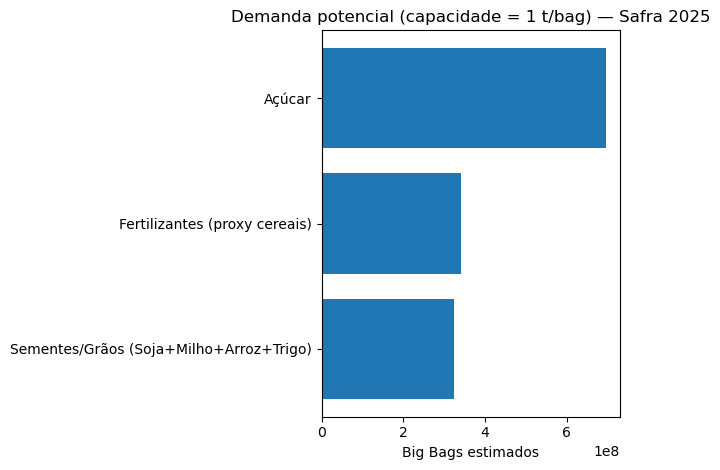

In [8]:

base = resumo.sort_values("bigbags_estimados", ascending=True)
plt.figure()
plt.barh(base["segmento"], base["bigbags_estimados"])
plt.xlabel("Big Bags estimados")
plt.title(f"Demanda potencial (capacidade = 1 t/bag) — Safra {ano_ref}")
plt.tight_layout(); plt.show()


### Cenários: 1.0, 1.2 e 1.5 t/bag

In [9]:

capacidades = [1.0, 1.2, 1.5]
cenarios = []
for c in capacidades:
    cenarios.append({
        "capacidade_bag_t": c,
        "Açúcar": estimar_bigbags(prod_acucar_t, c),
        "Fertilizantes (proxy cereais)": estimar_bigbags(prod_fert_t, c),
        "Sementes/Grãos (Soja+Milho+Arroz+Trigo)": estimar_bigbags(prod_sem_gr_t, c),
    })
pd.DataFrame(cenarios)


,capacidade_bag_t,Açúcar,Fertilizantes (proxy cereais),Sementes/Grãos (Soja+Milho+Arroz+Trigo)
0,1.0,6.950852e+08,3.404520e+08,3.232847e+08
1,1.2,5.792377e+08,2.837100e+08,2.694039e+08
2,1.5,4.633901e+08,2.269680e+08,2.155231e+08


In [10]:
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd

# --- helpers de cálculo (usam o DataFrame "pivot" já criado acima) ---
def _sum_items(df, itens):
    mask = False
    for it in itens:
        # ancora no início do nome limpo do produto
        rx = rf'^{re.escape(it)}\b'
        mask = mask | df["produto_clean"].str.contains(rx, case=False, regex=True)
    return df.loc[mask, "producao_t"].sum()

def _sum_category(df, categoria_prefixo):
    rx = rf'^{re.escape(categoria_prefixo)}\b'
    return df.loc[df["produto_clean"].str.contains(rx, case=False, regex=True), "producao_t"].sum()

def _calc_resumo(ano_ref:int, capacidade_bag_t:float,
                 sementes_grãos=("Soja","Milho","Arroz","Trigo")) -> pd.DataFrame:
    if capacidade_bag_t <= 0:
        raise ValueError("Capacidade do Big Bag deve ser positiva.")
    df = pivot[pivot["ano_safra"]==ano_ref][["produto_clean","producao_t"]].dropna()

    prod_acucar = _sum_items(df, ["Cana-de-açúcar"])
    # Fertilizantes → proxy: categoria Cereais/Leguminosas/Oleaginosas
    prod_fert   = _sum_category(df, "Cereais, leguminosas e oleaginosas")
    # Sementes/Grãos → soma dos itens (editáveis via widget)
    prod_semgr  = _sum_items(df, list(sementes_grãos))

    resumo = pd.DataFrame({
        "segmento": ["Açúcar", "Fertilizantes (proxy cereais)", f"Sementes/Grãos ({'+'.join(sementes_grãos)})"],
        "ano_safra": ano_ref,
        "producao_t": [prod_acucar, prod_fert, prod_semgr],
    })
    resumo["capacidade_bag_t"]   = capacidade_bag_t
    resumo["bigbags_estimados"]  = (resumo["producao_t"] / capacidade_bag_t)
    return resumo

# --- widgets de controle ---
anos = sorted(pivot["ano_safra"].dropna().unique().tolist())
w_ano   = widgets.Dropdown(options=anos, value=max(anos), description="Safra")
w_cap   = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description="Cap. (t/bag)", readout_format=".1f")
w_seeds = widgets.Text(value="Soja,Milho,Arroz,Trigo", description="Itens p/ Sementes", layout=widgets.Layout(width="450px"))
w_export= widgets.Button(description="Exportar CSV", button_style="")

out = widgets.Output()

def _parse_seeds(text:str):
    # divide por vírgula, remove espaços e vazios
    itens = [t.strip() for t in text.split(",")]
    return tuple([t for t in itens if t])

def _render(*args):
    with out:
        clear_output(wait=True)
        seeds = _parse_seeds(w_seeds.value)
        resumo = _calc_resumo(w_ano.value, w_cap.value, sementes_grãos=seeds)

        # tabela
        display(resumo.style.format({"producao_t":"{:,.0f}", "bigbags_estimados":"{:,.0f}"}))

        # gráfico
        plt.figure()
        plt.barh(resumo["segmento"], resumo["bigbags_estimados"])
        plt.xlabel("Big Bags estimados")
        plt.title(f"Demanda potencial — Safra {w_ano.value} | Capacidade {w_cap.value:.1f} t/bag")
        plt.tight_layout()
        plt.show()

def _on_export_clicked(btn):
    seeds = _parse_seeds(w_seeds.value)
    resumo = _calc_resumo(w_ano.value, w_cap.value, sementes_grãos=seeds)
    fname = f"projecoes_bigbags_{w_ano.value}_{str(w_cap.value).replace('.','_')}t.csv"
    resumo.to_csv(fname, index=False, encoding="utf-8")
    with out:
        print(f"CSV salvo: {fname}")

w_ano.observe(_render, names="value")
w_cap.observe(_render, names="value")
w_seeds.observe(_render, names="value")
w_export.on_click(_on_export_clicked)

controls = widgets.HBox([w_ano, w_cap])
controls2= widgets.HBox([w_seeds, w_export])
display(widgets.VBox([controls, controls2, out]))
_render()


In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

w_ano2   = widgets.Dropdown(options=anos, value=max(anos), description="Safra")
w_metric = widgets.ToggleButtons(
    options=[("Produção (t)","producao_t"), ("Produtividade (t/ha)","produtividade_t_ha")],
    value="producao_t", description="Métrica"
)
w_topn   = widgets.IntSlider(value=10, min=5, max=25, step=1, description="Top N")
w_minha  = widgets.IntSlider(value=10000, min=0, max=200000, step=5000, description="Área mín. (ha)")

out_rank = widgets.Output()

def _render_rank(*args):
    with out_rank:
        clear_output(wait=True)
        df = pivot[pivot["ano_safra"]==w_ano2.value].copy()
        if w_metric.value == "produtividade_t_ha":
            df = df[df["area_colhida_ha"] >= w_minha.value]
        df = df[~df["produto_clean"].str.lower().eq("total")]
        top = df.sort_values(w_metric.value, ascending=False).head(w_topn.value)

        display(top[["produto_clean","producao_t","area_colhida_ha","produtividade_t_ha"]]
                .style.format({"producao_t":"{:,.0f}","area_colhida_ha":"{:,.0f}","produtividade_t_ha":"{:,.3f}"}))

        plt.figure()
        plt.barh(top["produto_clean"][::-1], top[w_metric.value][::-1])
        xlabel = "Produção (t)" if w_metric.value=="producao_t" else "Produtividade (t/ha)"
        plt.xlabel(xlabel)
        plt.title(f"Ranking — Safra {w_ano2.value}")
        plt.tight_layout()
        plt.show()

for w in (w_ano2, w_metric, w_topn, w_minha):
    w.observe(_render_rank, names="value")

display(widgets.VBox([widgets.HBox([w_ano2, w_metric, w_topn, w_minha]), out_rank]))
_redit = _render_rank()


In [12]:
import numpy as np
import pandas as pd

df_prog = pivot.copy()

# Garantir produtividade (se vier NaN por algum motivo)
df_prog["produtividade_t_ha"] = df_prog["produtividade_t_ha"].where(
    df_prog["produtividade_t_ha"].notna(),
    df_prog["producao_t"] / df_prog["area_colhida_ha"]
)

# Área pendente = plantada - colhida (>=0)
df_prog["area_pendente_ha"] = np.maximum(df_prog["area_plantada_ha"] - df_prog["area_colhida_ha"], 0)

# Produção “realizada” pela produtividade atual vs área já colhida
df_prog["producao_realizada_t_calc"] = (df_prog["produtividade_t_ha"].fillna(0) * df_prog["area_colhida_ha"].fillna(0))

# Produção pendente = produtividade atual × área pendente
df_prog["producao_pendente_t_est"] = (df_prog["produtividade_t_ha"].fillna(0) * df_prog["area_pendente_ha"].fillna(0))

# Produção total estimada (realizada + pendente) para checagem
df_prog["producao_total_est_t"] = df_prog["producao_realizada_t_calc"] + df_prog["producao_pendente_t_est"]

# Safra de referência (mais recente)
ano_ref = int(df_prog["ano_safra"].max())

# Tabela por produto — safra mais recente
faltante_prod = (
    df_prog[df_prog["ano_safra"] == ano_ref]
    .loc[:, ["grupo","produto_clean","area_plantada_ha","area_colhida_ha","area_pendente_ha",
             "producao_t","produtividade_t_ha","producao_realizada_t_calc","producao_pendente_t_est","producao_total_est_t"]]
)

# Ordenar pelos maiores pendentes de produção
faltante_top = faltante_prod.sort_values("producao_pendente_t_est", ascending=False).head(25)
faltante_top.style.format({
    "area_plantada_ha": "{:,.0f}",
    "area_colhida_ha": "{:,.0f}",
    "area_pendente_ha": "{:,.0f}",
    "producao_t": "{:,.0f}",
    "producao_realizada_t_calc": "{:,.0f}",
    "producao_pendente_t_est": "{:,.0f}",
    "producao_total_est_t": "{:,.0f}",
    "produtividade_t_ha": "{:,.3f}",
})


,grupo,produto_clean,area_plantada_ha,area_colhida_ha,area_pendente_ha,producao_t,produtividade_t_ha,producao_realizada_t_calc,producao_pendente_t_est,producao_total_est_t
25,Brasil,Cana-de-açúcar,"9,323,767","9,241,643","82,124","695,085,205",75.212,"695,082,453","6,176,710","701,259,164"
31,Brasil,"Cereais, leguminosas e oleaginosas","81,643,003","81,215,186","427,817","340,451,981",4.192,"340,454,060","1,793,409","342,247,469"
51,Brasil,Milho (1ª Safra),"4,656,963","4,446,922","210,041","26,150,105",5.880,"26,147,901","1,235,041","27,382,942"
49,Brasil,Mandioca,"1,298,732","1,260,582","38,150","20,237,736",16.054,"20,237,383","612,460","20,849,844"
45,Brasil,Laranja,"538,489","527,555","10,934","12,832,137",24.324,"12,832,248","265,959","13,098,206"
55,Brasil,Soja,"47,633,313","47,573,015","60,298","165,536,108",3.480,"165,554,092","209,837","165,763,929"
53,Brasil,Milho (2ª Safra),"17,685,687","17,661,570","24,117","111,430,928",6.309,"111,426,845","152,154","111,578,999"
11,Brasil,Banana,"473,017","465,584","7,433","7,226,544",15.521,"7,226,329","115,368","7,341,697"
35,Brasil,Feijão (1ª Safra),"1,306,611","1,192,957","113,654","1,066,966",0.894,"1,066,504","101,607","1,168,110"
7,Brasil,Arroz,"1,755,325","1,752,531","2,794","12,467,535",7.114,"12,467,506","19,877","12,487,382"


Esta tabela resume, por cultura, o que já foi colhido, **o que falta colher e qual deve ser o total da safra**, com base nos dados do **LSPA/IBGE** do mês de setembro.

## Dicionário rápido das colunas

- grupo: recorte geográfico (ex.: Brasil).

- produto_clean: cultura (ex.: Cana-de-açúcar, Milho 1ª safra, Soja).

- area_plantada_ha: hectares plantados na safra.

- area_colhida_ha: hectares já colhidos até o mês de referência.

- area_pendente_ha: hectares que ainda faltam colher.

- area_pendente_ha = area_plantada_ha − area_colhida_ha (não negativo)

- producao_t: produção da safra informada pelo IBGE para o mês de referência.

- produtividade_t_ha: rendimento médio observado até agora.
- produtividade_t_ha = producao_t / area_colhida_ha

- producao_realizada_t_calc: produção já colhida (reconstituída pelo cálculo).
- producao_realizada_t_calc = produtividade_t_ha × area_colhida_ha

- producao_pendente_t_est: produção que ainda deve vir, estimada.
- producao_pendente_t_est = produtividade_t_ha × area_pendente_ha

- producao_total_est_t: checagem do total esperado.
- producao_total_est_t = producao_realizada_t_calc + producao_pendente_t_est

**Observação:** “producao_t” é a estimativa oficial do IBGE no mês; “producao_total_est_t” é uma reconstituição simples baseada na produtividade corrente. Use ambas como referência, não como valores exatos.

## Como interpretar

Progresso da colheita: compare area_colhida_ha com area_plantada_ha. Quanto menor a area_pendente_ha, mais avançada está a safra daquela cultura.

Volume que ainda vem: producao_pendente_t_est mostra o montante esperado até o fim, assumindo que a produtividade média atual se mantém.

Eficiência: use produtividade_t_ha para comparar culturas independentemente do tamanho da área

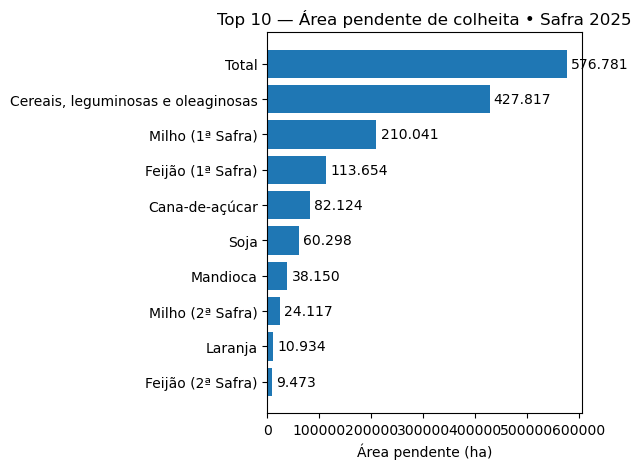

In [13]:
topn = 10  # ajuste se quiser mais/menos barras

top_area = faltante_prod.sort_values("area_pendente_ha", ascending=False).head(topn)

plt.figure()
bars = plt.barh(top_area["produto_clean"][::-1], top_area["area_pendente_ha"][::-1])
plt.xlabel("Área pendente (ha)")
plt.title(f"Top {topn} — Área pendente de colheita • Safra {ano_ref}")
add_bar_labels(bars, axis="h", nd=0, pad=3)
plt.tight_layout()
plt.show()


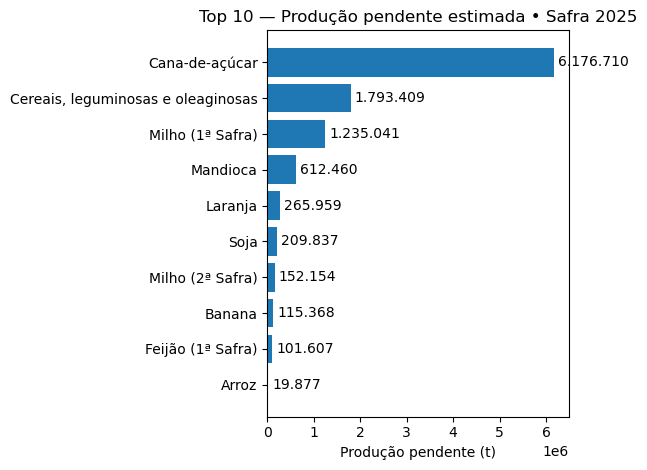

In [14]:
topn = 10  # ajuste se quiser mais/menos barras

top_prod = faltante_prod.sort_values("producao_pendente_t_est", ascending=False).head(topn)

plt.figure()
bars = plt.barh(top_prod["produto_clean"][::-1], top_prod["producao_pendente_t_est"][::-1])
plt.xlabel("Produção pendente (t)")
plt.title(f"Top {topn} — Produção pendente estimada • Safra {ano_ref}")
add_bar_labels(bars, axis="h", nd=0, pad=3)
plt.tight_layout()
plt.show()


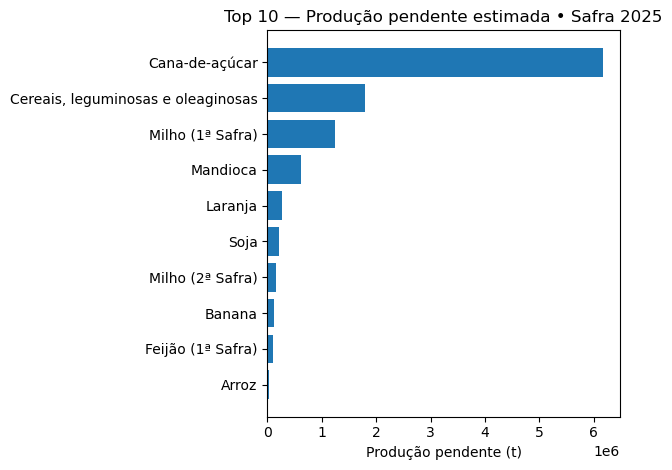

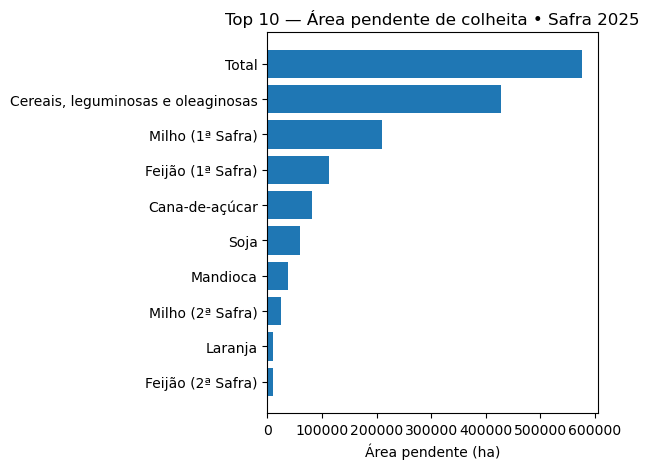

In [15]:
import matplotlib.pyplot as plt

# Top 10 por produção pendente
top10_pendente = faltante_prod.sort_values("producao_pendente_t_est", ascending=False).head(10)

plt.figure()
plt.barh(top10_pendente["produto_clean"][::-1], top10_pendente["producao_pendente_t_est"][::-1])
plt.xlabel("Produção pendente (t)")
plt.title(f"Top 10 — Produção pendente estimada • Safra {ano_ref}")
plt.tight_layout()
plt.show()

# Top 10 por área pendente
top10_area = faltante_prod.sort_values("area_pendente_ha", ascending=False).head(10)

plt.figure()
plt.barh(top10_area["produto_clean"][::-1], top10_area["area_pendente_ha"][::-1])
plt.xlabel("Área pendente (ha)")
plt.title(f"Top 10 — Área pendente de colheita • Safra {ano_ref}")
plt.tight_layout()
plt.show()
